In [1]:
pip install -U sentence-transformers

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


What specific references say. 

Word of mouth cannot be used at all. Not enough detail. 

And my language style. 

https://onlinelibrary.wiley.com/doi/full/10.1111/j.1551-6709.2010.01106.x

Mitchell Lapata Data can be found ^

To Do:
	- How much does BERT agree with Humans? W2V? GloVe?
	- Fine Tune BERT
	- Take context vectiors of whole sentence and use that
	- Remake the W2V dimensionality with these words

# Sadrzadeh-Kartsaklis-TransativeWordData Import

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA

In [4]:
# read the text file into a pandas dataframe
#df = pd.read_csv('Sadrzadeh-Kartsaklis-TransativeWordData.txt', sep=' ')
df = pd.read_csv('Data/LargerSadrKartTransative.txt', sep=' ')

# assign column names to the dataframe
df.columns = ['annotator', 'subject1', 'verb1', 'object1', 'subject2', 'verb2', 'object2', 'score']

# group the data by the three sentence columns and calculate the mean and standard deviation of the score column
grouped_data = df.groupby(['subject1', 'verb1', 'object1', 'subject2', 'verb2', 'object2']).agg({'score': [np.mean, np.std]}).reset_index()

# flatten the multi-level column names of the grouped data
grouped_data.columns = [' '.join(col).strip() for col in grouped_data.columns.values]

# rename the mean and std columns to 'score' and 'range' respectively
grouped_data.rename(columns={'score mean': 'score', 'score std': 'range'}, inplace=True)
grouped_data['score'] = grouped_data['score']/grouped_data['score'].max()

unique_word_list = []
for ind, row in grouped_data.iterrows():
	for i in [row['subject1'],row['verb1'],row['object1'], row['subject2'],row['verb2'],row['object2']]:
		unique_word_list.append(i)
unique_word_list = list(set(unique_word_list)) #Makes word_list from word_list's unique elements

grouped_data.describe()

FileNotFoundError: [Errno 2] No such file or directory: 'A.txt'

# Categories:

In [4]:
low = grouped_data[grouped_data['score'] < 1.157609]

high = grouped_data[grouped_data['score'] > 3.166667]

    subject1  verb1   object1  subject2     verb2  object2     score     range
0      agent   sell  property    family       buy     home  0.507305  1.541104
1      agent   sell  property     group      hold  meeting  0.189394  0.481543
2     author  write      book  delegate       buy     land  0.183512  0.625543
3     author  write      book       man      hear     word  0.266234  1.036018
4     author  write      book    writer      read     word  0.514069  1.090140
..       ...    ...       ...       ...       ...      ...       ...       ...
103    woman  drink     water    doctor       use     test  0.182630  0.448427
104    woman  drink     water    system       use   method  0.175866  0.408248
105   worker   join     party  employee     leave  company  0.227273  0.577350
106   writer   read      word    family   receive   letter  0.339433  1.341963
107   writer   read      word    people  remember     name  0.233766  0.768115

[108 rows x 8 columns]


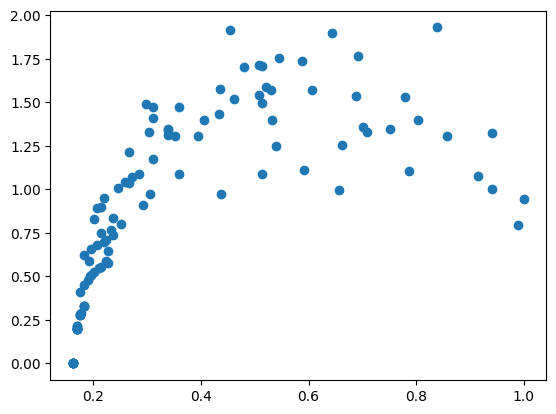

In [17]:
print(grouped_data)
plt.scatter( grouped_data['score'], grouped_data['range'])

# Adding Word Similarities

In [6]:
from CustomClasses.Models import *

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\henry\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
c:\Users\henry\Desktop\MastersProject\QC_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## BERT

In [7]:
bertWords = BertEncodingWords()
W2V_768 = W2VModel(768)

BERT_similarities_subject, W2V_similarities_subject, BERT_similarities_verb, W2V_similarities_verb, BERT_similarities_obj, W2V_similarities_obj = [], [], [],[],[],[]

#Loop through rows and calculate the subject-subject, verb-verb adn obj-obj cosine differences
#each row has: index subject1  verb1   object1  subject2     verb2  object2     score     range
#get word embeddings by: bertWords.getWordVector(string_word) and W2V_768.getvector(string_word)
#I use try-except to catch words missing from Word2Vec and place np.nan
for ind, row in grouped_data.iterrows():
	BERT_similarities_subject.append(1-cosine(bertWords.getWordVector(row['subject1']), bertWords.getWordVector(row['subject2'])))
	try:W2V_similarities_subject.append(1-cosine(W2V_768.getvector(row['subject1']), W2V_768.getvector(row['subject2'])))
	except:W2V_similarities_subject.append(np.nan)
	BERT_similarities_verb.append(1-cosine(bertWords.getWordVector(row['verb1']), bertWords.getWordVector(row['verb2'])))
	try:W2V_similarities_verb.append(1-cosine(W2V_768.getvector(row['verb1']), W2V_768.getvector(row['verb2'])))
	except:W2V_similarities_verb.append(np.nan)
	BERT_similarities_obj.append(1-cosine(bertWords.getWordVector(row['object1']), bertWords.getWordVector(row['object2'])))
	try:W2V_similarities_obj.append(1-cosine(W2V_768.getvector(row['object1']), W2V_768.getvector(row['object2'])))
	except:W2V_similarities_obj.append(np.nan)

grouped_data['BERT_subject_sim'] = BERT_similarities_subject
grouped_data['BERT_verb_sim'] = BERT_similarities_verb
grouped_data['BERT_obj_sim'] = BERT_similarities_obj
grouped_data['W2V_subject_sim'] = W2V_similarities_subject
grouped_data['W2V_verb_sim'] = W2V_similarities_verb
grouped_data['W2V_obj_sim'] = W2V_similarities_obj
grouped_data['W2V_sent'] = (grouped_data['W2V_subject_sim']+ grouped_data['W2V_verb_sim']+grouped_data['W2V_obj_sim'])/3
grouped_data['BERT_sent'] = (grouped_data['BERT_subject_sim']+ grouped_data['BERT_verb_sim']+grouped_data['BERT_obj_sim'])/3
grouped_data=grouped_data.fillna(0)
grouped_data.corr(method='spearman')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\henry\AppData\Local\Temp\ipykernel_46828\3391212652.py:30: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a 

,score,range,BERT_subject_sim,BERT_verb_sim,BERT_obj_sim,W2V_subject_sim,W2V_verb_sim,W2V_obj_sim,W2V_sent,BERT_sent
score,1.000000,0.858698,0.340849,0.329089,0.474223,0.135341,0.226604,0.272606,0.210911,0.564433
range,0.858698,1.000000,0.147164,0.226609,0.349284,0.073978,0.168534,0.149325,0.092748,0.359957
BERT_subject_sim,0.340849,0.147164,1.000000,0.041824,0.441065,0.100924,-0.120257,0.234692,0.157658,0.754442
BERT_verb_sim,0.329089,0.226609,0.041824,1.000000,0.103331,0.043413,0.293372,0.084630,0.173658,0.491081
BERT_obj_sim,0.474223,0.349284,0.441065,0.103331,1.000000,0.003721,-0.038876,0.346344,0.054745,0.728807
W2V_subject_sim,0.135341,0.073978,0.100924,0.043413,0.003721,1.000000,-0.043085,0.113217,0.712480,0.118653
W2V_verb_sim,0.226604,0.168534,-0.120257,0.293372,-0.038876,-0.043085,1.000000,0.093086,0.384983,0.037747
W2V_obj_sim,0.272606,0.149325,0.234692,0.084630,0.346344,0.113217,0.093086,1.000000,0.560749,0.318055
W2V_sent,0.210911,0.092748,0.157658,0.173658,0.054745,0.712480,0.384983,0.560749,1.000000,0.228742
BERT_sent,0.564433,0.359957,0.754442,0.491081,0.728807,0.118653,0.037747,0.318055,0.228742,1.000000


# Plot Analysis of raw BERT

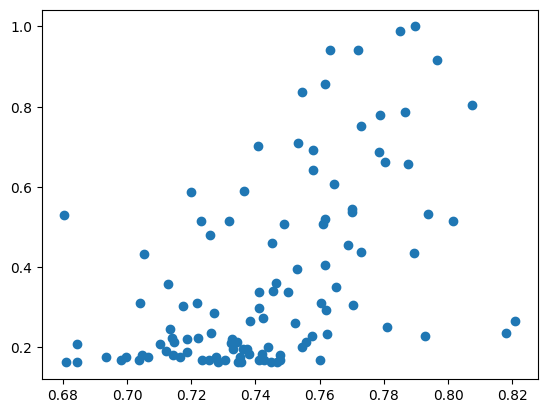

In [8]:
plt.scatter((grouped_data['BERT_subject_sim']+ grouped_data['BERT_verb_sim']+grouped_data['BERT_obj_sim'])/3, grouped_data['score'])

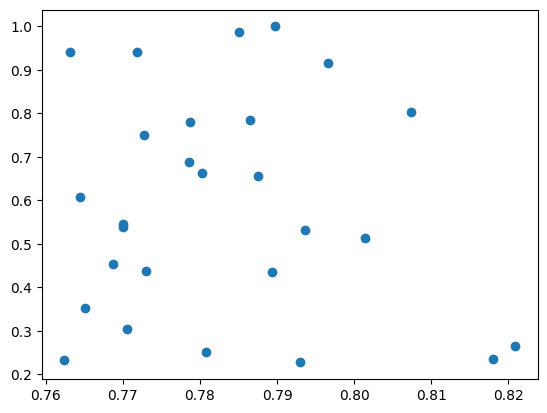

In [9]:
BERT_sim =(grouped_data['BERT_subject_sim']+ grouped_data['BERT_verb_sim']+grouped_data['BERT_obj_sim'])/3
plt.scatter(BERT_sim[BERT_sim>0.762111], grouped_data[BERT_sim>0.762111]['score'])

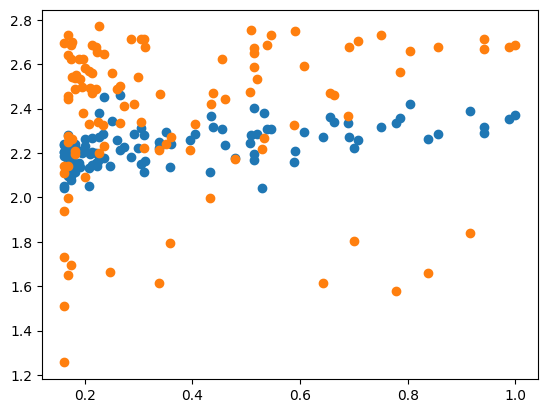

In [10]:
plt.scatter(grouped_data['score'], grouped_data['BERT_subject_sim']+ grouped_data['BERT_verb_sim']+grouped_data['BERT_obj_sim'])
plt.scatter(grouped_data['score'], grouped_data['W2V_subject_sim']+ grouped_data['W2V_verb_sim']+grouped_data['W2V_obj_sim'])

Linear Coefficients:  [ 1.09090304  1.78688748  1.22635888 -0.05372821 -0.09929324  0.14581601]


Text(0, 0.5, 'Score')

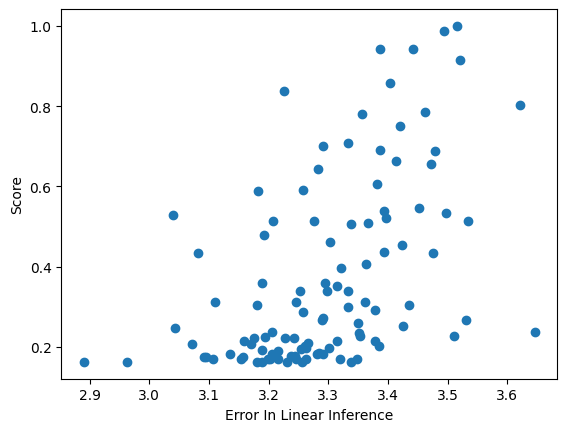

In [11]:
import sklearn
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(grouped_data[["BERT_subject_sim","BERT_verb_sim","BERT_obj_sim","W2V_subject_sim","W2V_verb_sim","W2V_obj_sim"]].fillna(0), grouped_data['score'])
print("Linear Coefficients: ",  reg.coef_)

plt.scatter(1.09090304  *grouped_data['BERT_subject_sim']+
            1.78688748  *grouped_data['BERT_verb_sim']+
            1.22635888 *grouped_data['BERT_obj_sim'] -
            -0.05372821*grouped_data['W2V_subject_sim'] -
            -0.09929324*grouped_data['W2V_verb_sim'] +
            0.14581601*grouped_data['W2V_obj_sim']
            ,grouped_data['score'])
plt.xlabel("Error In Linear Inference")
plt.ylabel("Score")

In [9]:
grouped_data.to_csv("DatasetPhraseWordSimilarities.csv")

# New PreTrained BERT Model

In [13]:
from transformers import BertTokenizer, BertForSequenceClassification

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [55]:
import torch

# Load the pre-trained model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Tokenize the word and convert the tokens to IDs
BERT_similarities_subject, W2V_similarities_subject, BERT_similarities_verb,BERT_similarities_obj, BERT_similarities_sent = [], [], [],[],[]

for ind, row in grouped_data.iterrows():
	rows_embeddings = []
	for i in [row['subject1'],row['verb1'],row['object1'], row['subject2'],row['verb2'],row['object2']]:
		tokens= tokenizer.tokenize(i)
		token_ids = tokenizer.convert_tokens_to_ids(tokens)
		token_tensor = torch.tensor([token_ids])
		with torch.no_grad():
			embeddings = model.bert(token_tensor)[0]
		rows_embeddings.append(embeddings)

	sent1 = row['subject1']+" "+row['verb1']+" "+row['object1']
	sent2 = row['subject2']+" "+row['verb2']+" "+row['object2']
	for i in [sent1, sent2]:
		tokens= tokenizer.tokenize(i)
		token_ids = tokenizer.convert_tokens_to_ids(tokens)
		token_tensor = torch.tensor([token_ids])
		with torch.no_grad():
			embeddings = model.bert(token_tensor)[0]
		rows_embeddings.append(embeddings)
	
	#print(rows_embeddings[1] .size())
	BERT_similarities_subject.append(1-cosine(rows_embeddings[0][-1][-1] ,rows_embeddings[3][-1][-1] ))
	BERT_similarities_verb.append(1-cosine(rows_embeddings[1][-1][-1] , rows_embeddings[4][-1][-1] ))
	BERT_similarities_obj.append(1-cosine(rows_embeddings[2][-1][-1], rows_embeddings[5][-1][-1] ))
	BERT_similarities_sent.append(1-cosine(rows_embeddings[6][-1][-1] , rows_embeddings[7][-1][-1] ))
	#print(ind, len(BERT_similarities_subject)-1, len(BERT_similarities_verb)-1, len(BERT_similarities_obj)-1, len(BERT_similarities_sent)-1)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [58]:
grouped_data['BERT_subject_sim'] = BERT_similarities_subject 
grouped_data['BERT_verb_sim'] = BERT_similarities_verb
grouped_data['BERT_obj_sim'] = BERT_similarities_obj
grouped_data['BERT_sent_sim'] = BERT_similarities_sent
grouped_data.corr(method='spearman')

C:\Users\henry\AppData\Local\Temp\ipykernel_46828\1766200153.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  grouped_data.corr(method='spearman')


,score,range,BERT_subject_sim,BERT_verb_sim,BERT_obj_sim,BERT_sent_sim
score,1.000000,0.858698,0.073484,0.047186,0.145973,0.274014
range,0.858698,1.000000,0.073047,0.000495,0.056828,0.181120
BERT_subject_sim,0.073484,0.073047,1.000000,-0.066299,0.084152,0.299091
BERT_verb_sim,0.047186,0.000495,-0.066299,1.000000,-0.160037,-0.043420
BERT_obj_sim,0.145973,0.056828,0.084152,-0.160037,1.000000,0.078373
BERT_sent_sim,0.274014,0.181120,0.299091,-0.043420,0.078373,1.000000


# New FineTuned BERT Model

In [4]:
grouped_data

,subject1,verb1,object1,subject2,verb2,object2,score,range
0,agent,sell,property,family,buy,home,0.507305,1.541104
1,agent,sell,property,group,hold,meeting,0.189394,0.481543
2,author,write,book,delegate,buy,land,0.183512,0.625543
3,author,write,book,man,hear,word,0.266234,1.036018
4,author,write,book,writer,read,word,0.514069,1.090140
...,...,...,...,...,...,...,...,...
103,woman,drink,water,doctor,use,test,0.182630,0.448427
104,woman,drink,water,system,use,method,0.175866,0.408248
105,worker,join,party,employee,leave,company,0.227273,0.577350
106,writer,read,word,family,receive,letter,0.339433,1.341963


In [40]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, Dataset

# Define a custom dataset class for similarity scoring
class SimilarityDataset(Dataset):
	def __init__(self, df, tokenizer, max_len):
		self.df = df
		self.tokenizer = tokenizer
		self.max_len = max_len

	def __len__(self):
		return len(self.df)

	def __getitem__(self, index):
		row = self.df.iloc[index]
		sentence1 = row['subject1'] + ' ' + row['verb1'] + ' ' + row['object1']
		sentence2 = row['subject2'] + ' ' + row['verb2'] + ' ' + row['object2']
		score = row['score']
		encoding = self.tokenizer.encode_plus(
			sentence1,
			sentence2,
			add_special_tokens=True,
			padding='max_length',
			max_length=self.max_len,
			truncation=True,
			return_tensors='pt'
		)
		return encoding['input_ids'], encoding['attention_mask'], torch.tensor(score, dtype=torch.float)

# Load the dataset
df = grouped_data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = SimilarityDataset(df, tokenizer, max_len=10)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

# Load the pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

# Set the model to train mode and move it to GPU if available
model.train()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the optimizer and the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = torch.nn.MSELoss()

# Train the model
for epoch in range(10):
	total_loss = 0
	for batch in train_loader:
		input_ids = batch[0].to(device)
		input_ids = torch.squeeze(input_ids, dim=1)
		attention_mask = batch[1].to(device)
		labels = batch[2].to(device)
		outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels.unsqueeze(1))
		loss = loss_fn(outputs.logits.squeeze(), labels)
		loss = loss.float()
		loss.backward()
		optimizer.step()

	print(f'Epoch {epoch+1}: average loss = {total_loss/len(train_loader):.4f}')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1: average loss = 0.0000
Epoch 2: average loss = 0.0000
Epoch 3: average loss = 0.0000
Epoch 4: average loss = 0.0000
Epoch 5: average loss = 0.0000
Epoch 6: average loss = 0.0000
Epoch 7: average loss = 0.0000
Epoch 8: average loss = 0.0000
Epoch 9: average loss = 0.0000
Epoch 10: average loss = 0.0000


In [42]:
# Tokenize the word and convert the tokens to IDs
BERT_similarities_subject, W2V_similarities_subject, BERT_similarities_verb,BERT_similarities_obj, BERT_similarities_sent = [], [], [],[],[]

for ind, row in grouped_data.iterrows():
	rows_embeddings = []
	for i in [row['subject1'],row['verb1'],row['object1'], row['subject2'],row['verb2'],row['object2']]:
		tokens= tokenizer.tokenize(i)
		token_ids = tokenizer.convert_tokens_to_ids(tokens)
		token_tensor = torch.tensor([token_ids])
		with torch.no_grad():
			embeddings = model.bert(token_tensor)[0]
		rows_embeddings.append(embeddings)

	sent1 = row['subject1']+" "+row['verb1']+" "+row['object1']
	sent2 = row['subject2']+" "+row['verb2']+" "+row['object2']
	for i in [sent1, sent2]:
		tokens= tokenizer.tokenize(i)
		token_ids = tokenizer.convert_tokens_to_ids(tokens)
		token_tensor = torch.tensor([token_ids])
		with torch.no_grad():
			embeddings = model.bert(token_tensor)[0]
		rows_embeddings.append(embeddings)
	
	#print(rows_embeddings[1] .size())
	BERT_similarities_subject.append(1-cosine(rows_embeddings[0][-1][-1] ,rows_embeddings[3][-1][-1] ))
	BERT_similarities_verb.append(1-cosine(rows_embeddings[1][-1][-1] , rows_embeddings[4][-1][-1] ))
	BERT_similarities_obj.append(1-cosine(rows_embeddings[2][-1][-1], rows_embeddings[5][-1][-1]))
	BERT_similarities_sent.append(1-cosine(rows_embeddings[6][-1][-1], rows_embeddings[7][-1][-1]))
	#print(ind, len(BERT_similarities_subject)-1, len(BERT_similarities_verb)-1, len(BERT_similarities_obj)-1, len(BERT_similarities_sent)-1)

In [49]:
grouped_data['BERT_subject_sim'] = BERT_similarities_subject 
grouped_data['BERT_verb_sim'] = BERT_similarities_verb
grouped_data['BERT_obj_sim'] = BERT_similarities_obj
grouped_data['BERT_sent_sim'] = BERT_similarities_sent
grouped_data.corr(method='spearman')

C:\Users\henry\AppData\Local\Temp\ipykernel_42940\1766200153.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  grouped_data.corr(method='spearman')


,score,range,BERT_subject_sim,BERT_verb_sim,BERT_obj_sim,BERT_sent_sim
score,1.000000,0.858698,-0.085636,0.001830,0.121901,0.095604
range,0.858698,1.000000,-0.004016,0.065979,0.091768,0.033888
BERT_subject_sim,-0.085636,-0.004016,1.000000,-0.097802,-0.024474,-0.106081
BERT_verb_sim,0.001830,0.065979,-0.097802,1.000000,0.020835,-0.050082
BERT_obj_sim,0.121901,0.091768,-0.024474,0.020835,1.000000,-0.028838
BERT_sent_sim,0.095604,0.033888,-0.106081,-0.050082,-0.028838,1.000000


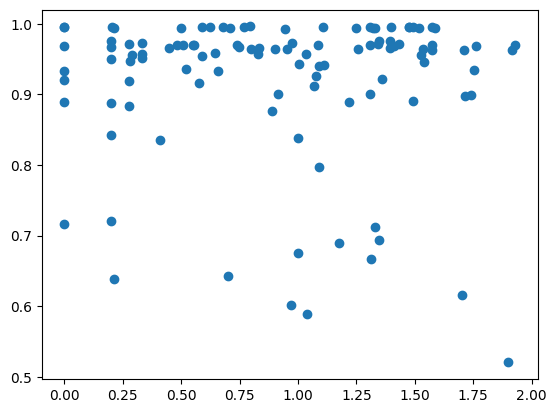

In [53]:
plt.scatter(grouped_data['range'], grouped_data['BERT_sent_sim'])

# Sentance Embeddings

In [8]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')

SENT_similarities_subject = []

for ind, row in grouped_data.iterrows():
	rows_embeddings = []
	sent1 = row['subject1']+" "+row['verb1']+" "+row['object1']
	sent1_embeddings = embedder.encode(sent1)
	#sent1_embeddings = sent1_embeddings /  sent1_embeddings.max()
	sent2 = row['subject2']+" "+row['verb2']+" "+row['object2']
	sent2_embeddings = embedder.encode(sent2)
	#sent2_embeddings = sent2_embeddings /  sent2_embeddings.max()
	SENT_similarities_subject.append(1-cosine(sent1_embeddings, sent2_embeddings))

grouped_data['SENT_sent_sim'] = SENT_similarities_subject
grouped_data.corr(method='spearman')

C:\Users\henry\AppData\Local\Temp\ipykernel_8752\4293460152.py:18: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  grouped_data.corr(method='spearman')


,score,range,SENT_sent_sim
score,1.000000,0.858698,0.797066
range,0.858698,1.000000,0.598361
SENT_sent_sim,0.797066,0.598361,1.000000


(0.1, 1.1)

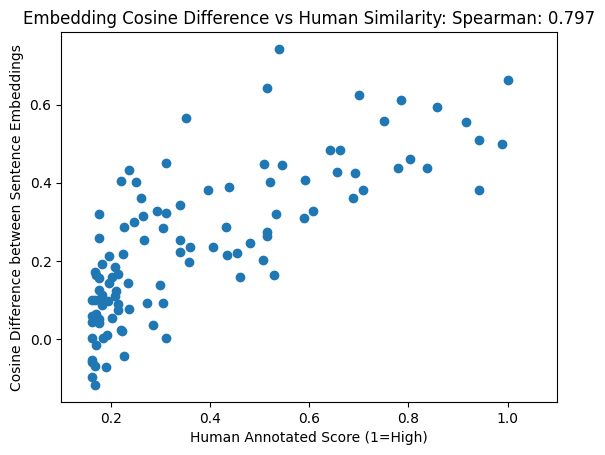

In [6]:
plt.scatter(grouped_data['score'], grouped_data['SENT_sent_sim'])
plt.title("Embedding Cosine Difference vs Human Similarity: Spearman: "+str(round(grouped_data['score'].corr(grouped_data['SENT_sent_sim'], method='spearman'), 3)))
plt.xlabel("Human Annotated Score (1=High)")
plt.ylabel("Cosine Difference between Sentence Embeddings")
plt.xlim(left=0.1, right=1.1)

(0.0, 1.0)

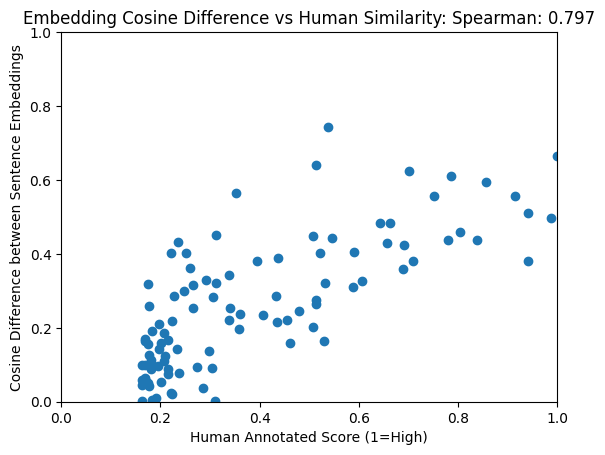

In [7]:
plt.scatter(grouped_data['score'], grouped_data['SENT_sent_sim'])
plt.title("Embedding Cosine Difference vs Human Similarity: Spearman: "+str(round(grouped_data['score'].corr(grouped_data['SENT_sent_sim'], method='spearman'), 3)))
plt.xlabel("Human Annotated Score (1=High)")
plt.ylabel("Cosine Difference between Sentence Embeddings")
plt.xlim(left=0, right=1)
plt.ylim(bottom=0, top=1)

# Word Embeddings with Sentence Embedder

In [9]:
BERT_similarities_subject,BERT_similarities_verb,BERT_similarities_obj   = [],[],[]

for ind, row in grouped_data.iterrows():
	rows_embeddings = []
	for i in [row['subject1'],row['verb1'],row['object1'], row['subject2'],row['verb2'],row['object2']]:
		rows_embeddings.append(embedder.encode(i))
	sent1 = row['subject1']+" "+row['verb1']+" "+row['object1']
	sent1_embeddings = embedder.encode(sent1)
	BERT_similarities_subject.append(1-cosine(rows_embeddings[0] ,rows_embeddings[3]))
	BERT_similarities_verb.append(1-cosine(rows_embeddings[1] , rows_embeddings[4]))
	BERT_similarities_obj.append(1-cosine(rows_embeddings[2] , rows_embeddings[5]))

grouped_data['SENT_sub_sim'] = BERT_similarities_subject
grouped_data['SENT_verb_sim'] = BERT_similarities_verb
grouped_data['SENT_obj_sim'] = BERT_similarities_obj
grouped_data['sum'] = (grouped_data['SENT_obj_sim'] +grouped_data['SENT_verb_sim'] +grouped_data['SENT_sub_sim'])/3
grouped_data.corr(method='spearman')

C:\Users\henry\AppData\Local\Temp\ipykernel_8752\2732982021.py:17: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  grouped_data.corr(method='spearman')


,score,range,SENT_sent_sim,SENT_sub_sim,SENT_verb_sim,SENT_obj_sim,sum
score,1.000000,0.858698,0.797066,0.630270,0.458983,0.558049,0.746846
range,0.858698,1.000000,0.598361,0.403131,0.446381,0.495584,0.580353
SENT_sent_sim,0.797066,0.598361,1.000000,0.786958,0.420281,0.632657,0.864033
SENT_sub_sim,0.630270,0.403131,0.786958,1.000000,0.245219,0.418000,0.784862
SENT_verb_sim,0.458983,0.446381,0.420281,0.245219,1.000000,0.218815,0.623512
SENT_obj_sim,0.558049,0.495584,0.632657,0.418000,0.218815,1.000000,0.713626
sum,0.746846,0.580353,0.864033,0.784862,0.623512,0.713626,1.000000


(0.1, 1.1)

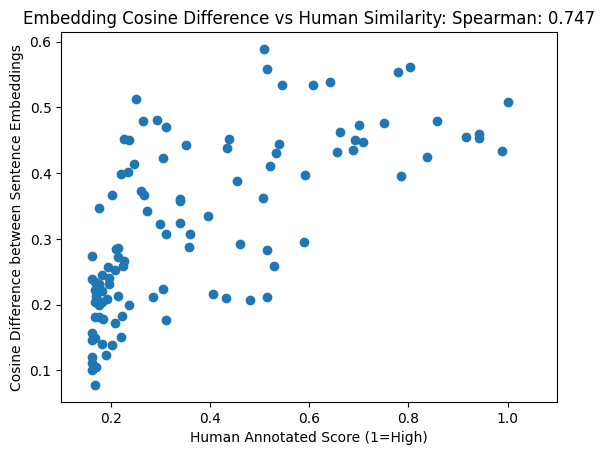

In [9]:
plt.scatter(grouped_data['score'], grouped_data['sum'])
plt.title("Embedding Cosine Difference vs Human Similarity: Spearman: "+str(round(grouped_data['score'].corr(grouped_data['sum'], method='spearman'), 3)))
plt.xlabel("Human Annotated Score (1=High)")
plt.ylabel("Cosine Difference between Sentence Embeddings")
plt.xlim(left=0.1, right=1.1)

# Dimension Reduction

In [10]:
def DimReduceByPCA(input_array, new_dims):
	pca = PCA(n_components = new_dims)
	pca.fit(input_array)
	data_pca = pca.transform(input_array)
	return data_pca

def DimReduceBySVD(input_array, new_dims):
    U, D, Vt = np.linalg.svd(input_array)
    U_reduced = U[:, :new_dims]
    A_reduced = np.dot(U_reduced, np.diag(D))
    return A_reduced

def RotateWordVector(input_word_vector):
	rotated_word_vector = np.zeroes(len(unique_word_list))
	for index, comaprison_word in enumerate(unique_word_list):
		rotated_word_vector[index] = (1-cosine(input_word_vector, embedder.encode(comaprison_word)))
	return rotated_word_vector

In [11]:
#Making a dict of words as keys do our dimensionality vectors: {word: {dim_method : vector}}
corpus_array = np.zeros(shape=(len(unique_word_list), 384))
word_vector_dict = {}
for i, word in enumerate(unique_word_list):
		vector = embedder.encode(word)
		word_vector_dict.update({word: {len(vector):vector}})
		corpus_array[i] = vector

pca_dim = 10
pca = DimReduceByPCA(corpus_array, pca_dim)
for i, word in enumerate(unique_word_list):
		word_vector_dict[word].update({"pca_"+str(pca_dim):pca[i]})

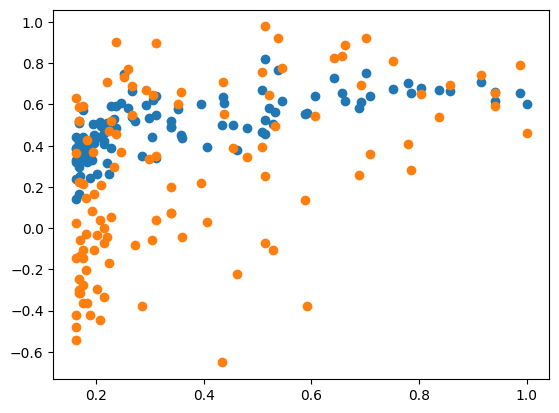

In [12]:
similarities = []
for ind, row in grouped_data.iterrows():
	rows_embeddings = []
	sent1 = word_vector_dict[row['subject1']][384] + word_vector_dict[row['verb1']][384] + word_vector_dict[row['object1']][384]
	sent2 = word_vector_dict[row['subject2']][384] + word_vector_dict[row['verb2']][384] + word_vector_dict[row['object2']][384]

	sent1_170 = word_vector_dict[row['subject1']]["pca_"+str(pca_dim)] + word_vector_dict[row['verb1']]["pca_"+str(pca_dim)] + word_vector_dict[row['object1']]["pca_"+str(pca_dim)]
	sent2_170 = word_vector_dict[row['subject2']]["pca_"+str(pca_dim)] + word_vector_dict[row['verb2']]["pca_"+str(pca_dim)] + word_vector_dict[row['object2']]["pca_"+str(pca_dim)]
	similarities.append([1-cosine(sent1, sent2), 1-cosine(sent1_170, sent2_170)])

similarities = np.array(similarities)
plt.scatter(grouped_data['score'], similarities[:,0])
plt.scatter(grouped_data['score'], similarities[:,1])

In [13]:
grouped_data['PCA_'+str(pca_dim)] = similarities[:,1]
grouped_data.corr(method='spearman')

C:\Users\henry\AppData\Local\Temp\ipykernel_8752\3695999218.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  grouped_data.corr(method='spearman')


,score,range,SENT_sent_sim,SENT_sub_sim,SENT_verb_sim,SENT_obj_sim,sum,PCA_10
score,1.000000,0.858698,0.797066,0.630270,0.458983,0.558049,0.746846,0.537317
range,0.858698,1.000000,0.598361,0.403131,0.446381,0.495584,0.580353,0.399214
SENT_sent_sim,0.797066,0.598361,1.000000,0.786958,0.420281,0.632657,0.864033,0.721874
SENT_sub_sim,0.630270,0.403131,0.786958,1.000000,0.245219,0.418000,0.784862,0.616374
SENT_verb_sim,0.458983,0.446381,0.420281,0.245219,1.000000,0.218815,0.623512,0.454426
SENT_obj_sim,0.558049,0.495584,0.632657,0.418000,0.218815,1.000000,0.713626,0.527056
sum,0.746846,0.580353,0.864033,0.784862,0.623512,0.713626,1.000000,0.750198
PCA_10,0.537317,0.399214,0.721874,0.616374,0.454426,0.527056,0.750198,1.000000


In [14]:
grouped_data

,subject1,verb1,object1,subject2,verb2,object2,score,range,SENT_sent_sim,SENT_sub_sim,SENT_verb_sim,SENT_obj_sim,sum,PCA_10
0,agent,sell,property,family,buy,home,0.507305,1.541104,0.201549,0.111137,0.687575,0.287326,0.362013,0.394433
1,agent,sell,property,group,hold,meeting,0.189394,0.481543,-0.071638,0.127501,0.288967,-0.046184,0.123428,-0.419797
2,author,write,book,delegate,buy,land,0.183512,0.625543,0.003442,0.157430,0.166433,0.211330,0.178398,-0.365270
3,author,write,book,man,hear,word,0.266234,1.036018,0.252530,0.338995,0.372899,0.388278,0.366724,0.551217
4,author,write,book,writer,read,word,0.514069,1.090140,0.641656,0.755711,0.529858,0.388278,0.557949,0.978626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,woman,drink,water,doctor,use,test,0.182630,0.448427,0.192133,0.172855,0.355742,0.207168,0.245255,0.427217
104,woman,drink,water,system,use,method,0.175866,0.408248,0.125207,0.107123,0.355742,0.230542,0.231135,-0.363076
105,worker,join,party,employee,leave,company,0.227273,0.577350,0.285479,0.751912,0.395919,0.208960,0.452264,0.521499
106,writer,read,word,family,receive,letter,0.339433,1.341963,0.253634,0.239393,0.252427,0.481148,0.324322,0.074801


# Quantum Encoding

In [15]:
import lambeq as lq
import pennylane as pl
import numpy as np

from lambeq import BobcatParser
from discopy import grammar

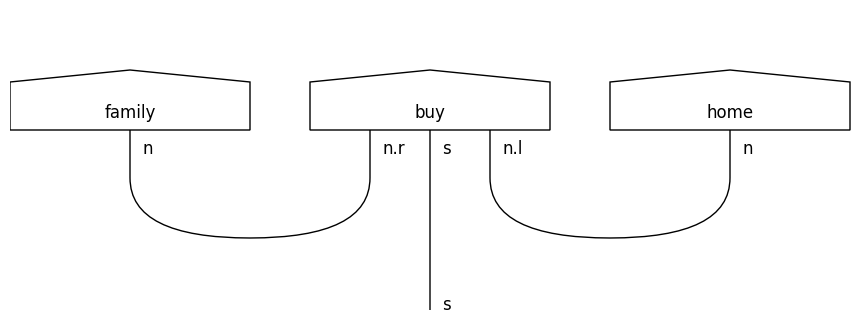

In [16]:
ith_row = 0
jth_of_rows_sent_pair = 1 #1 or 2
sentence1 = grouped_data['subject'+str(jth_of_rows_sent_pair)][ith_row] + " " + grouped_data['verb'+str(jth_of_rows_sent_pair)][ith_row]  + " " + grouped_data['object'+str(jth_of_rows_sent_pair)][ith_row] 
jth_of_rows_sent_pair = 2 #1 or 2
sentence2 = grouped_data['subject'+str(jth_of_rows_sent_pair)][ith_row] + " " + grouped_data['verb'+str(jth_of_rows_sent_pair)][ith_row]  + " " + grouped_data['object'+str(jth_of_rows_sent_pair)][ith_row] 

# Parse the sentence and convert it into a string diagram
parser = BobcatParser(verbose='suppress')
#diagram = parser.sentence2diagram(sentence1)
diagram = parser.sentence2diagram(sentence2)

grammar.draw(diagram, figsize=(14,3), fontsize=12)

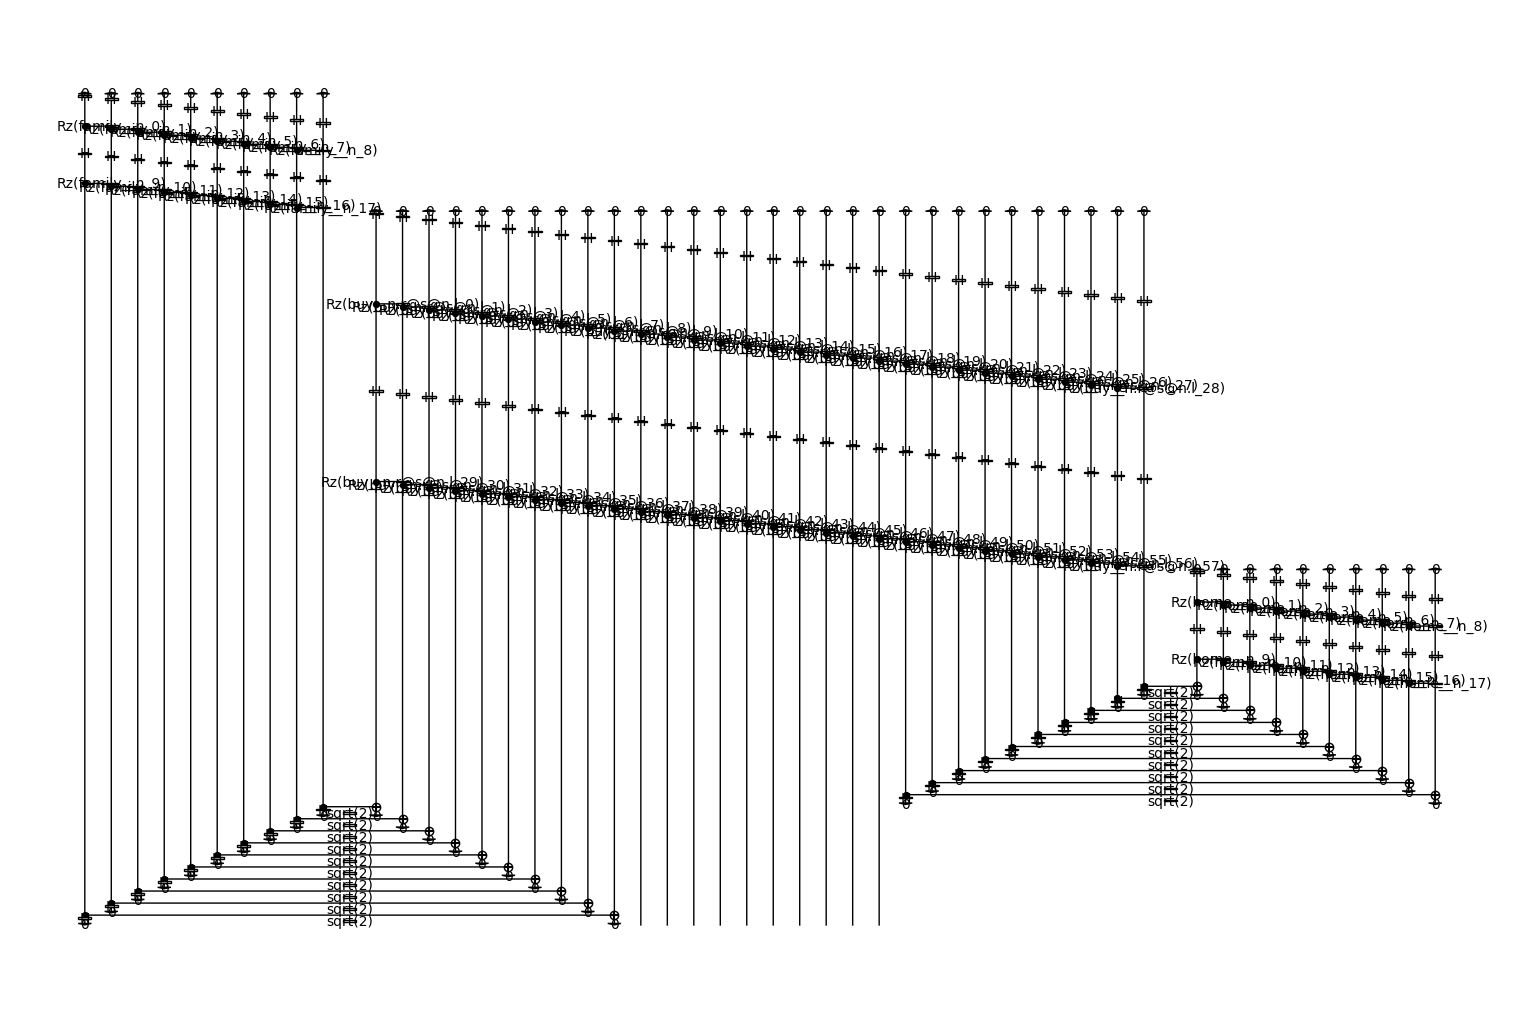

In [18]:
from lambeq import AtomicType, IQPAnsatz

# Define atomic types
N = AtomicType.NOUN
S = AtomicType.SENTENCE

# Convert string diagram to quantum circuit
ansatz = IQPAnsatz({N: 10, S: 10}, n_layers=2)
discopy_circuit = ansatz(diagram)
discopy_circuit.draw(figsize=(15,10))

In [57]:
vector1 = word_vector_dict['agent']["pca_"+str(pca_dim)] + word_vector_dict['sell']["pca_"+str(pca_dim)] + word_vector_dict['property']["pca_"+str(pca_dim)]
vector1 = vector1/vector1.max()

vector2 = word_vector_dict['family']["pca_"+str(pca_dim)] + word_vector_dict['buy']["pca_"+str(pca_dim)] + word_vector_dict['home']["pca_"+str(pca_dim)]
vector2 = vector2/vector2.max()
1-cosine(vector1, vector2)

0.3944328661214511

In [63]:
device = pl.device("default.qubit", wires=len(vector1))

@pl.qnode(device)
def PL_AngleEncode(vector):
	pl.AngleEmbedding(vector, range(len(vector)), "Z")
	for i in range(len(vector)):
		pl.Hadamard(i)
	return pl.probs(wires=range(len(vector)))

circuit = pl.QNode(PL_AngleEncode, device)


print(pl.draw(circuit, expansion_strategy="device")(vector1))

0: ──RZ(0.66)───H─┤ ╭Probs
1: ──RZ(0.53)───H─┤ ├Probs
2: ──RZ(0.01)───H─┤ ├Probs
3: ──RZ(1.00)───H─┤ ├Probs
4: ──RZ(0.26)───H─┤ ├Probs
5: ──RZ(0.55)───H─┤ ├Probs
6: ──RZ(-0.08)──H─┤ ├Probs
7: ──RZ(0.24)───H─┤ ├Probs
8: ──RZ(-0.02)──H─┤ ├Probs
9: ──RZ(-0.16)──H─┤ ╰Probs


In [81]:
device = pl.device('default.qubit', wires=len(vector1))

@pl.qnode(device)
def PL_AmplitudeEncode(vector):
	pl.AmplitudeEmbedding(features=vector, wires=range(len(vector)), pad_with=0., normalize=True)
	for i in range(len(vector)):
		pl.Hadamard(i)
	return pl.probs(wires=range(len(vector)))

circuit = pl.QNode(PL_AmplitudeEncode, device)
print(pl.draw(circuit, expansion_strategy="device")(vector1))
device.state

0: ─╭QubitStateVector(M0)──H─┤ ╭Probs
1: ─├QubitStateVector(M0)──H─┤ ├Probs
2: ─├QubitStateVector(M0)──H─┤ ├Probs
3: ─├QubitStateVector(M0)──H─┤ ├Probs
4: ─├QubitStateVector(M0)──H─┤ ├Probs
5: ─├QubitStateVector(M0)──H─┤ ├Probs
6: ─├QubitStateVector(M0)──H─┤ ├Probs
7: ─├QubitStateVector(M0)──H─┤ ├Probs
8: ─├QubitStateVector(M0)──H─┤ ├Probs
9: ─╰QubitStateVector(M0)──H─┤ ╰Probs


array([1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])

In [ ]:
from lambeq import PennyLaneModel

backend_config = {'shots': 1000}
model = PennyLaneModel.from_diagrams(all_circuits,
                                     backend_config=backend_config)